In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/Dataset/FPUS23_Dataset.zip', './FPUS23_Dataset.zip')

'./FPUS23_Dataset.zip'

In [ ]:
%ls

config.py      drive/     FPUS23_Dataset.zip  model.py      utils.py
data_setup.py  engine.py  main.py             sample_data/


In [ ]:
!unzip FPUS23_Dataset.zip

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

# Our custom modules
import config
from data_setup import create_dataloaders
from utils import get_device
from model import UNET
from engine import train_step, test_step

In [ ]:
print("--- Setting up configuration and device ---")
# Set seed for reproducibility
torch.manual_seed(config.RANDOM_SEED)

# Select hardware device
device = get_device()

--- Setting up configuration and device ---
Using device: cuda


In [ ]:
print("\n--- Creating DataLoaders ---")
train_loader, test_loader = create_dataloaders(
    anno_path=config.ANNO_PATH,
    img_path=config.IMG_PATH,
    batch_size=config.BATCH_SIZE,
    train_split_ratio=config.TRAIN_SPLIT_RATIO,
    image_size=config.IMAGE_SIZE,
    random_seed=config.RANDOM_SEED,
    num_workers=config.NUM_WORKERS
)
print(f"\nNumber of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")


--- Creating DataLoaders ---
Total images found: 15113
Training dataset size: 12090
Testing dataset size: 3023

Number of batches in train_loader: 756
Number of batches in test_loader: 189



--- Visualizing a data sample ---
Found a sample with annotations at index 2 in the batch.


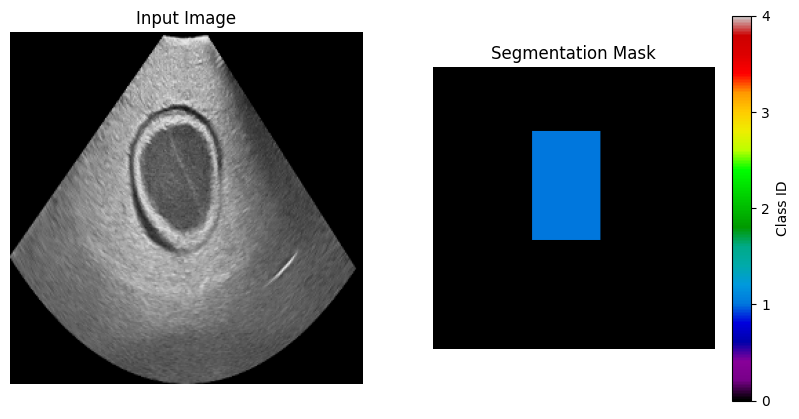

In [ ]:
print("\n--- Visualizing a data sample ---")
# Fetch one batch to visualize
images, masks = next(iter(train_loader))

# Find the first image in the batch that has a non-background mask
img_to_plot = None
mask_to_plot = None
for i in range(config.BATCH_SIZE):
    if torch.any(masks[i] > 0):
        img_to_plot = images[i].permute(1, 2, 0).cpu().numpy()
        mask_to_plot = masks[i].cpu().numpy()
        print(f"Found a sample with annotations at index {i} in the batch.")
        break

if img_to_plot is None:
    print("Could not find a sample with annotations in the first batch. Plotting the first sample anyway.")
    img_to_plot = images[0].permute(1, 2, 0).cpu().numpy()
    mask_to_plot = masks[0].cpu().numpy()

# Plot the image and the mask side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_to_plot)
ax[0].set_title("Input Image")
ax[0].axis("off")
im = ax[1].imshow(mask_to_plot, cmap='nipy_spectral', vmin=0, vmax=config.NUM_CLASSES - 1)
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")
cbar = fig.colorbar(im, ax=ax[1], ticks=range(config.NUM_CLASSES))
cbar.set_label('Class ID')
plt.show()

In [ ]:
print("\n--- Initializing the Model ---")
# Initialize the model
model = UNET(in_channels=config.IN_CHANNELS, out_classes=config.NUM_CLASSES).to(device)

# Print a summary
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"U-Net model initialized and moved to {device}.")
print(f"Model has {num_params:,} trainable parameters.")

# Test forward pass with one batch
with torch.no_grad():
    sample_images = images.to(device)
    output = model(sample_images)
    print(f"\nTest forward pass successful!")
    print(f"Input shape:  {sample_images.shape}")
    print(f"Output shape: {output.shape}")


--- Initializing the Model ---
U-Net model initialized and moved to cuda.
Model has 17,263,237 trainable parameters.

Test forward pass successful!
Input shape:  torch.Size([16, 3, 256, 256])
Output shape: torch.Size([16, 5, 256, 256])


In [ ]:
print("\n--- Setting up Loss and Optimizer ---")
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=config.LEARNING_RATE)
print("Loss function and optimizer are set up.")


--- Setting up Loss and Optimizer ---
Loss function and optimizer are set up.



--- Starting training for 5 epochs ---

Epoch 1/5


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

  Train Loss: 0.6085 | Val Loss: 0.2676 | Val Dice Score: 0.5654
  New best model found! Dice score improved from 0.0000 to 0.5654.
  Saving model to fetus_unet_model.pth...

Epoch 2/5


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

  Train Loss: 0.1883 | Val Loss: 0.1322 | Val Dice Score: 0.7716
  New best model found! Dice score improved from 0.5654 to 0.7716.
  Saving model to fetus_unet_model.pth...

Epoch 3/5


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

  Train Loss: 0.1173 | Val Loss: 0.0967 | Val Dice Score: 0.8186
  New best model found! Dice score improved from 0.7716 to 0.8186.
  Saving model to fetus_unet_model.pth...

Epoch 4/5


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

  Train Loss: 0.0898 | Val Loss: 0.0979 | Val Dice Score: 0.8339
  New best model found! Dice score improved from 0.8186 to 0.8339.
  Saving model to fetus_unet_model.pth...

Epoch 5/5


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

  Train Loss: 0.0726 | Val Loss: 0.0646 | Val Dice Score: 0.8740
  New best model found! Dice score improved from 0.8339 to 0.8740.
  Saving model to fetus_unet_model.pth...

--- Training finished! ---


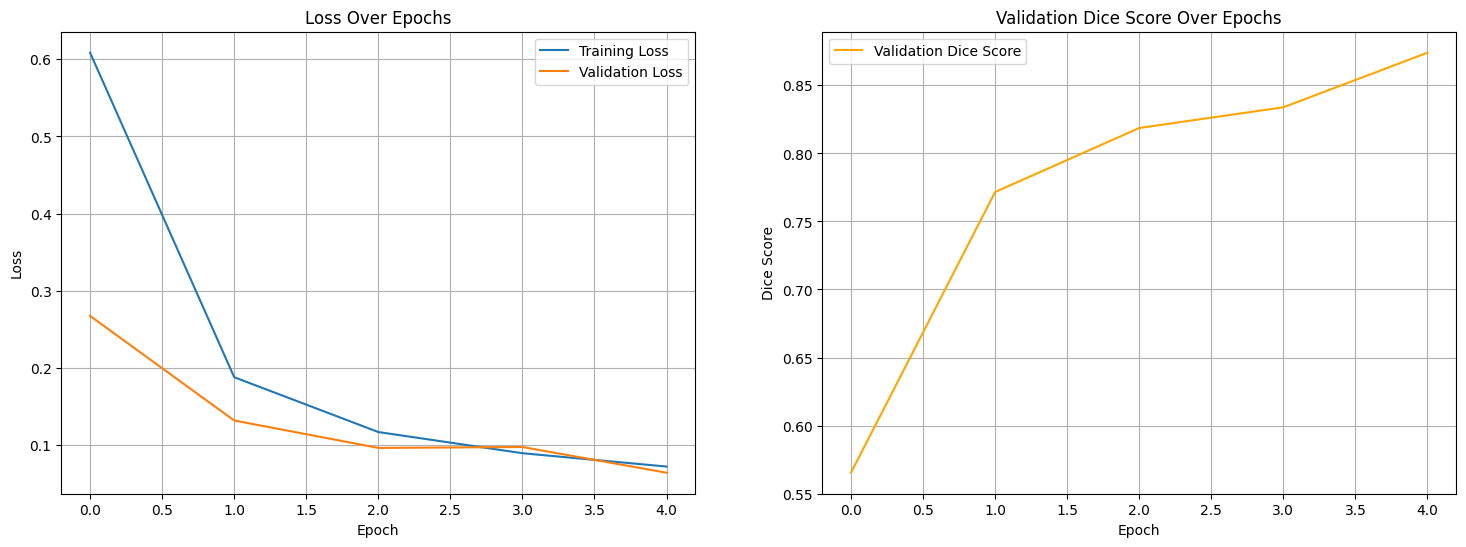

In [ ]:
print(f"\n--- Starting training for {config.EPOCHS} epochs ---")
history = {"train_loss": [], "val_loss": [], "val_dice": []}
best_dice_score = 0.0

for epoch in range(config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.EPOCHS}")
    train_loss = train_step(model=model,
                            dataloader=train_loader,
                            loss_fn=criterion,
                            optimizer=optimizer,
                            device=device)

    val_loss, val_dice = test_step(model=model,
                                   dataloader=test_loader,
                                   loss_fn=criterion,
                                   device=device,
                                   num_classes=config.NUM_CLASSES)

    print(
        f"  Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Dice Score: {val_dice:.4f}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_dice)

    if val_dice > best_dice_score:
        print(f"  New best model found! Dice score improved from {best_dice_score:.4f} to {val_dice:.4f}.")
        best_dice_score = val_dice
        print(f"  Saving model to {config.MODEL_SAVE_PATH}...")
        torch.save(model.state_dict(), config.MODEL_SAVE_PATH)

print("\n--- Training finished! ---")

# Plot the training and validation loss & Dice score
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(history['train_loss'], label='Training Loss')
ax[0].plot(history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history['val_dice'], label='Validation Dice Score', color='orange')
ax[1].set_title('Validation Dice Score Over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice Score')
ax[1].legend()
ax[1].grid(True)
plt.show()


--- Testing the Best Model ---
Model loaded and set to evaluation mode.


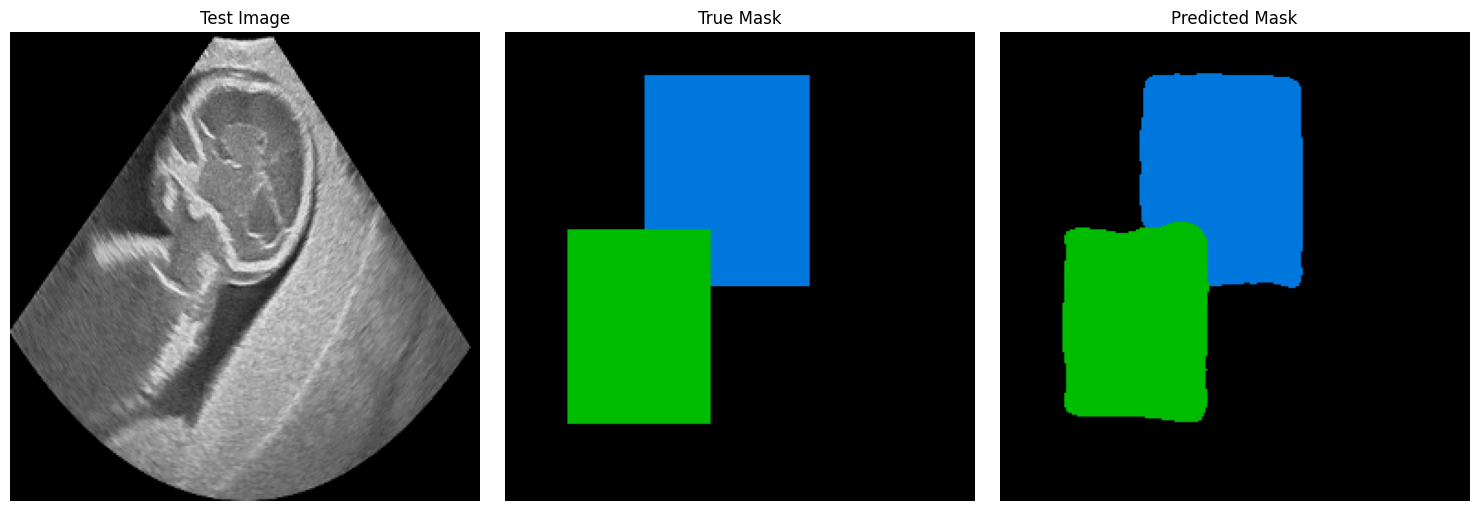

In [ ]:
print("\n--- Testing the Best Model ---")

loaded_model = UNET(in_channels=config.IN_CHANNELS, out_classes=config.NUM_CLASSES)
loaded_model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
loaded_model.to(device)
loaded_model.eval()
print("Model loaded and set to evaluation mode.")

# Perform Inference on a Test Image
test_images, test_masks = next(iter(test_loader))
sample_image = test_images[0].unsqueeze(0).to(device)
true_mask = test_masks[0]

with torch.no_grad():
    prediction = loaded_model(sample_image)

pred_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu().numpy()

# Visualize the result
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_images[0].permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Test Image")
ax[0].axis("off")
ax[1].imshow(true_mask.cpu().numpy(), cmap='nipy_spectral', vmin=0, vmax=config.NUM_CLASSES - 1)
ax[1].set_title("True Mask")
ax[1].axis("off")
ax[2].imshow(pred_mask, cmap='nipy_spectral', vmin=0, vmax=config.NUM_CLASSES - 1)
ax[2].set_title("Predicted Mask")
ax[2].axis("off")
plt.tight_layout()
plt.show()

--- Step 1: Initializing Model Architecture ---
Model instance created.

--- Step 2: Loading Saved Weights ---
Attempting to load model from: fetus_unet_model.pth
Model weights loaded successfully.
Model moved to device: cuda

--- Step 3: Setting up Optimizer and Loss Function ---
Optimizer and loss function are ready.

--- Step 4: Establishing Baseline Performance ---


Validating:   0%|          | 0/189 [00:00<?, ?it/s]

Loaded model's starting Dice Score: 0.8740

--- Step 5: Resuming Training for 5 More Epochs ---


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.0586 | Val Loss: 0.0857 | Val Dice Score: 0.8252


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.0489 | Val Loss: 0.0622 | Val Dice Score: 0.8841
  New best model found! Dice score improved from 0.8740 to 0.8841.
  Saving updated best model to fetus_unet_model.pth...


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.0435 | Val Loss: 0.0435 | Val Dice Score: 0.9184
  New best model found! Dice score improved from 0.8841 to 0.9184.
  Saving updated best model to fetus_unet_model.pth...


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.0381 | Val Loss: 0.0416 | Val Dice Score: 0.9178


Training:   0%|          | 0/756 [00:00<?, ?it/s]

Validating:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.0340 | Val Loss: 0.0702 | Val Dice Score: 0.9117

--- Resumed training finished! ---


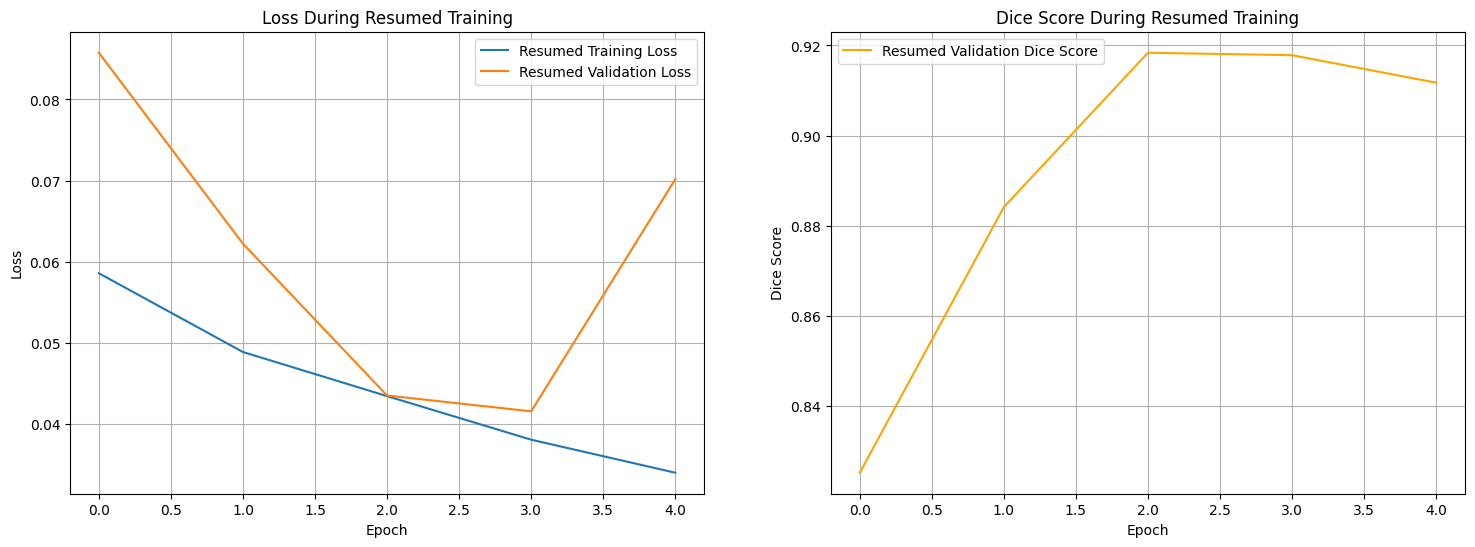

In [ ]:
# --- CELL: LOAD SAVED MODEL AND RESUME TRAINING ---

import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

# The modules should already be imported, but we ensure they are available
import config
from model import UNET
from engine import train_step, test_step

print("--- Step 1: Initializing Model Architecture ---")
# First, create a new instance of the model. It must have the same
# architecture as the one you saved.
model = UNET(in_channels=config.IN_CHANNELS, out_classes=config.NUM_CLASSES)
print("Model instance created.")


print("\n--- Step 2: Loading Saved Weights ---")
# Load the saved weights (the state_dict) from your Google Drive
try:
    print(f"Attempting to load model from: {config.MODEL_SAVE_PATH}")
    # Use map_location=device to ensure the model loads correctly onto the Colab GPU/CPU
    model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, map_location=device))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Model file not found at {config.MODEL_SAVE_PATH}. Cannot resume training.")
    print("Please ensure you have already trained and saved a model.")
    # Stop execution of this cell if the file doesn't exist.
    raise

# Move the model (with its loaded weights) to the correct device
model.to(device)
print(f"Model moved to device: {device}")


print("\n--- Step 3: Setting up Optimizer and Loss Function ---")
# The optimizer MUST be re-initialized for the loaded model's parameters.
optimizer = Adam(model.parameters(), lr=config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
print("Optimizer and loss function are ready.")


print("\n--- Step 4: Establishing Baseline Performance ---")
# Run one validation step first to see the performance of the loaded model.
# This sets the 'best_dice_score' to beat.
_, best_dice_score = test_step(model, test_loader, criterion, device, config.NUM_CLASSES)
print(f"Loaded model's starting Dice Score: {best_dice_score:.4f}")


print(f"\n--- Step 5: Resuming Training for {config.EPOCHS} More Epochs ---")
history = {"train_loss": [], "val_loss": [], "val_dice": []}

for epoch in range(config.EPOCHS):
    train_loss = train_step(model=model,
                            dataloader=train_loader,
                            loss_fn=criterion,
                            optimizer=optimizer,
                            device=device)

    val_loss, val_dice = test_step(model=model,
                                   dataloader=test_loader,
                                   loss_fn=criterion,
                                   device=device,
                                   num_classes=config.NUM_CLASSES)

    print(
        f"Epoch: {epoch+1}/{config.EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Dice Score: {val_dice:.4f}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_dice)

    # Save the model only if its performance has improved
    if val_dice > best_dice_score:
        print(f"  New best model found! Dice score improved from {best_dice_score:.4f} to {val_dice:.4f}.")
        best_dice_score = val_dice
        print(f"  Saving updated best model to {config.MODEL_SAVE_PATH}...")
        torch.save(model.state_dict(), config.MODEL_SAVE_PATH)

print("\n--- Resumed training finished! ---")

# Plot the results from THIS training session
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(history['train_loss'], label='Resumed Training Loss')
ax[0].plot(history['val_loss'], label='Resumed Validation Loss')
ax[0].set_title('Loss During Resumed Training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history['val_dice'], label='Resumed Validation Dice Score', color='orange')
ax[1].set_title('Dice Score During Resumed Training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice Score')
ax[1].legend()
ax[1].grid(True)

plt.show()

In [ ]:
from google.colab import files
import os


print(f"Preparing to download model from: {config.MODEL_SAVE_PATH}")

# First, check if the model file actually exists at the path
if os.path.exists(config.MODEL_SAVE_PATH):
    # If it exists, initiate the download
    files.download(config.MODEL_SAVE_PATH)
    print("\nDownload initiated. Please check your browser's download bar.")
else:
    # If the file is not found, print a helpful error message
    print("\nERROR: Model file not found!")
    print(f"Could not find a file at the path: {config.MODEL_SAVE_PATH}")
    print("Please ensure that the training process completed successfully and saved a model.")

Preparing to download model from: fetus_unet_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download initiated. Please check your browser's download bar.
